# Описание чат-бота:

## 4 интента:

### 1) Разговорная на базе файла ответов mail.ru
### 2) Перевод текста
### 3) Сообщает точное время 
### 4) Говорит "Рад был помочь!"

Разговорная часть - FastText, annoy 

Перевод текста - FSMTForConditionalGeneration, FSMTTokenizer

Время и рад был помочь - простой препроцессинг

In [28]:
!pip install torch

In [29]:
import torch

In [30]:
import tensorflow as tf

In [31]:
from tensorflow import keras

In [32]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [33]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
tf.test.is_built_with_cuda()

True

In [35]:
print(tf.version.VERSION)

2.6.0


In [36]:
import sys

In [37]:
sys.version

'3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]'

In [39]:
!pip install python-telegram-bot --upgrade

In [40]:
!pip install pymorphy2 stop_words annoy

In [41]:
!pip install gensim

In [42]:
!pip install tdqm

In [43]:
!pip install numpy scipy scikit-learn
!pip install pandas

In [45]:
!pip install ipywidgets

In [46]:
import os
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
import logging
from telegram import Update
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import re
from functools import lru_cache
import datetime

In [47]:
# assert True

# question = None
# written = False

# with open("prepared_answers.txt", "w", encoding="utf8") as fout:
#     with open("Otvety!.txt", "r", encoding="utf8") as fin:
#         for line in tqdm_notebook(fin):
#             if line.startswith("---"):
#                 written = False
#                 continue
#             if not written and question is not None:
#                 fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
#                 written = True
#                 question = None
#                 continue
#             if not written:
#                 question = line.strip()
#                 continue

In [48]:
@lru_cache(maxsize=None)
def parse_morpher(text):
    return morpher.parse(text)[0].normal_form

In [49]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [parse_morpher(re.sub(r'\<[^>]*\>', '', i).lower()) for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [50]:
def preprocess_txt1(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [51]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [52]:
# %%time
# sentences = []

# with open("Otvety!.txt", "r", encoding="utf8") as fin:
#     for line in tqdm_notebook(fin):
#         spls = preprocess_txt(line)
#         sentences.append(spls)
#         
# sentences = [i for i in sentences if len(i) > 2]

In [53]:
# len(sentences)

In [54]:
# %%time
# modelFT = FastText(sentences=sentences, vector_size=100, min_count=1, window=5)
# modelFT.save('modelFT')

In [55]:
SIZE_EMB = 100  # Размер эмбеддинга

In [56]:
modelFT = FastText.load('modelFT')

In [57]:
%%time
ft_index = annoy.AnnoyIndex(SIZE_EMB, 'angular')
index_map = {}
counter = 0

with open('prepared_answers.txt', "r", encoding="utf8") as f:
    for line in tqdm_notebook(f):
        n_ft = 0
        spls = line.split("\t")
        index_map[counter] = re.sub(r'\<[^>]*\>', '', spls[1]) 
        question = preprocess_txt(spls[0])
        vector_ft = np.zeros(SIZE_EMB)
        
        for word in question:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word]
                n_ft += 1
        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index.add_item(counter, vector_ft)
        counter += 1
        
ft_index.build(10)
ft_index.save('ft_index')

<timed exec>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

CPU times: total: 4min 28s
Wall time: 3min 37s


True

In [58]:
ft_index = annoy.AnnoyIndex(SIZE_EMB, 'angular')
ft_index.load('ft_index') 

True

In [59]:
ft_index.get_nns_by_vector(np.zeros(SIZE_EMB), 2)

[2818, 26651]

In [60]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1 
            n_ft += 1 
    return vector_ft / n_ft

In [61]:
# Проверка языка текста

def is_english(text):
    return bool(re.search(r'[a-zA-Z]', text))

In [62]:
list_for_translation = ['перевод', 'английский','перевести']
list_for_time = ['время','час','сколько сейчас времени', 'какой час']
list_for_thank = ['спасибо']

In [63]:
# Проверка есть ли совпадение со списком ключевых слов

def is_in_list(text, list):
    for word in text:
        if word in list:
            return True
            break
    return False

In [64]:
!pip install transformers

In [65]:
!pip install sacremoses

In [66]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer

In [67]:
model_name = "facebook/wmt19-en-ru"
tokenizer = FSMTTokenizer.from_pretrained(model_name)

In [68]:
model = FSMTForConditionalGeneration.from_pretrained(model_name)

In [69]:
# Функция перевода

def en_ru_translation(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(input_ids)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return decoded 

In [70]:
updater = Updater(token='5878020676:AAEz3AdRsNCuNqjT4Z0ISZ3NV5xVvln26-U') # Токен API к Telegram
dispatcher = updater.dispatcher

In [71]:
def startCommand(update: Update, context: CallbackContext):
    update.message.reply_text('Привет!Я могу сказать, который час, перевести предложение или поговорить')

In [72]:
def textMessage(update: Update, context: CallbackContext):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt1(update.message.text)
    
    # Перевод с английского
    if is_english(update.message.text) == True:
        update.message.reply_text(en_ru_translation(update.message.text))
    elif is_in_list(input_txt, list_for_translation) == True:
        update.message.reply_text("Какое предложение вам перевести?")
        
    #Сегодняшнее время
    
    elif is_in_list(input_txt1, list_for_time): 
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        
    #Благодарность
    
    elif is_in_list(input_txt1, list_for_thank):    
        update.message.reply_text('Рад был помочь!')

    # Разговорная часть
    else: 
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.35:
            print(distances[0])
            update.message.reply_text("Не понимаю тебя")
        else:
            update.message.reply_text(index_map[ft_index_val[0]])
            
    return

In [73]:
# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

# Start the Bot
updater.start_polling()
updater.idle()

C:\Users\Pavel_Nazarenko\anaconda3\envs\ev_1\lib\site-packages\transformers\generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


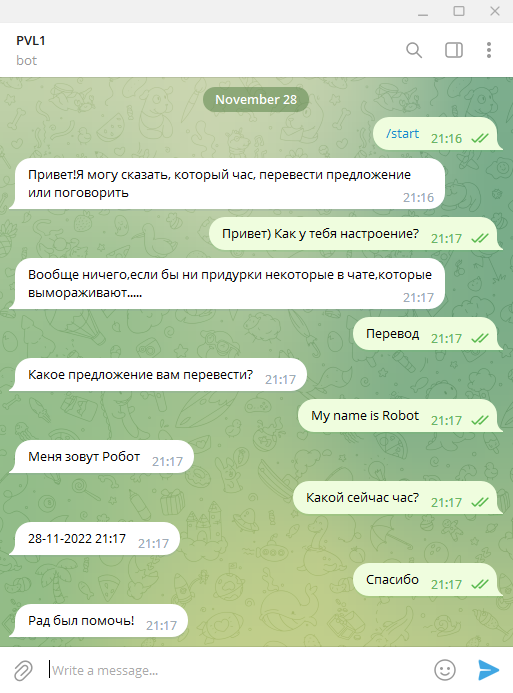

In [74]:
from IPython.display import Image
Image('BOT.png')